In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression
from statsmodels.tsa.stattools import coint
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sb

now_ = datetime.datetime.now()
now = now_.strftime("%Y-%m-%d")
print(now)


end_date = now
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

2021-03-13


In [2]:
# THIS IS MY PORTFOLIO FOR ASSET MANAGEMENT MANAGEMENT COMPETITION 2021 WHERE 20+ BUSINESS SCHOOLS COMPETE
# MY TEAM'S NAME IS 'ORACLES OF IMPERIAL', I AM ALLOCATING ALL THE STOCKS AND DETERMINING THEIR WEIGHTS
# I have used top-down approach to select my long stocks, and bottom-up approach to determine my short stocks
# You can realize that the portfolio is resilient to external shocks, correlation with the market is almost 0
# and the sharpe ratio is favorable
# portfolio delta is 0.7 for now


# These are weights and stocks of the portfolio for each week

long_weights = [[0.12, 0.05, 0.08, 0.06,
               0.06, 0.07, 0.05, 0.08,
               0.07, 0.09, 0.07, 0.05, 
                0.09, 0.06, 0.05],
               
               [0.12, 0.07, 0.07, 0.08,
               0.08, 0.05, 0.06, 0.04,
               0.07, 0.09, 0.07, 0.05, 
                0.09, 0.06, 0.07]]

short_weights = [[0.05, 0.06, 0.05, 0.05,
                0.03, 0.02, 0.04],
                
                [0.03, 0.04, 0.06, 0.06,
                0.03, 0.02, 0.04, 0.04]]

long_stocks = [['BRK-b', 'HSBA.L', 'TSLA', 
            'HUM', 'C', 'GS', 'CNP.PA', 'CVX', 
               'CINE.L', 'VOE.VI', 'AT1.DE', 
              'AIV', 'AV.L', 'BOSS.DE', 'NVO'],
               
              ['BRK-b', 'HSBA.L', 'ASML.AS', 
            'HUM', 'C', 'TOT', 'CNP.PA', 'CVX', 
               'CINE.L', 'VOE.VI', 'AT1.DE', 
              'AIV', 'AV.L', 'BOSS.DE', 'TGT']]

short_stocks = [['KMI', 'RMG.L', 'EVT.DE',
               'AFX.DE', 'CTEC.L', 'TOM.OL', 'XLNX'],
               
               ['KMI', 'RMG.L', 'UDR',
               'AFX.DE', 'CTEC.L', 'TOM.OL', 'QRVO', 'RCO.PA']]

In [3]:
import yfinance as yf
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()

def weekly_performance(weeks, week, start, long_weights, short_weights, long_stocks, short_stocks):
    
    longs = pd.DataFrame([])
    shorts = pd.DataFrame([])
    if week == weeks[-1]:
        for i in long_stocks[week]:
            longs[i] = pdr.get_data_yahoo(i, start=start[week], end=end_date)['Adj Close']
        for i in short_stocks[week]:
            shorts[i] = pdr.get_data_yahoo(i, start=start[week], end=end_date)['Adj Close']
    else:
        date_end = datetime.datetime(2021, 2, 26) + relativedelta(days=8)
        date_end = date_end.strftime("%Y-%m-%d")
        
        for i in long_stocks[week]:
            longs[i] = pdr.get_data_yahoo(i, start=start[week], end=date_end)['Adj Close']
        for i in short_stocks[week]:
            shorts[i] = pdr.get_data_yahoo(i, start=start[week], end=date_end)['Adj Close']
  
    long_prices = longs[:]
    short_prices = shorts[:]
    
    for i in longs.columns:
        longs[i] = longs[i].pct_change()
    for i in shorts.columns:
        shorts[i] = shorts[i].pct_change()

    longs = longs.dropna()
    shorts = shorts.dropna()

    long_returns = pd.DataFrame([])
    for i in range(len(longs.columns)):
        long_returns[longs.columns[i]] = np.zeros(shape = (len(longs[longs.columns[i]])))
        for j in range(len(longs[long_returns.columns[i]])):
            if j == 0: 
                long_returns[longs.columns[i]][j] = 1000000*long_weights[week][i]*(1+longs[longs.columns[i]][j])
            else:
                long_returns[longs.columns[i]][j] = long_returns[longs.columns[i]][j-1]*(1+longs[longs.columns[i]][j])
            
    short_returns = pd.DataFrame([])
    for i in range(len(shorts.columns)):
        short_returns[shorts.columns[i]] = np.zeros(shape = (len(shorts[shorts.columns[i]])))
        for j in range(len(shorts[short_returns.columns[i]])):
            if j == 0: 
                short_returns[shorts.columns[i]][j] = 1000000*short_weights[week][i]*(1+shorts[shorts.columns[i]][j])
            else:
                short_returns[shorts.columns[i]][j] = short_returns[shorts.columns[i]][j-1]*(1+shorts[shorts.columns[i]][j])
    
    short_returns = -short_returns       
    portfolio = np.zeros(shape = (len(longs[longs.columns[i]])))
        
    long_sum = long_returns.sum(axis=1)
    short_sum = short_returns.sum(axis=1)
    portfolio = long_sum + short_sum
       
    performance = np.zeros(shape = (len(longs[longs.columns[i]])))
    
    portfolio_delta = 0
    for i in long_weights[week]:
        portfolio_delta += i*1000000
    for j in short_weights[week]:
        portfolio_delta += -j*1000000
    
    for j in range(len(portfolio)):
        if j == 0:
            performance[j] = (portfolio[j]-portfolio_delta)/(portfolio_delta + (1000000-portfolio_delta))
        else:
            performance[j] = (portfolio[j]-portfolio[j-1])/(portfolio[j-1] + (1000000-portfolio_delta))
            
    performers_long = pd.DataFrame([])
    performers_short = pd.DataFrame([])
    
    for i in range(len(longs.columns)):
        performers_long[longs.columns[i]] = np.zeros(shape = (1))
        performers_long[longs.columns[i]][0] = (long_prices[longs.columns[i]][len(long_prices[longs.columns[i]])-1]-long_prices[longs.columns[i]][0])/long_prices[longs.columns[i]][0]
        
    for i in range(len(shorts.columns)):
        performers_short[shorts.columns[i]] = np.zeros(shape = (1))
        performers_short[shorts.columns[i]][0] = (short_prices[shorts.columns[i]][len(short_prices[shorts.columns[i]])-1]-short_prices[shorts.columns[i]][0])/short_prices[shorts.columns[i]][0]
        

    performers_long = performers_long.sort_values(0, axis=1, ascending=False)
    performers_short = performers_short.sort_values(0, axis=1, ascending=True)
    
    print('\n\n')
    print('LONG SIDE PERFORMANCES OF WEEK {}'.format(week))
    print('--------------------------------')
    for i in performers_long.columns:
        result = (round(performers_long[i][0], 4))
        print('{}: {}%'.format(i, round(100*result, 3)))
    print('\n\n')

    print('SHORT SIDE PERFORMANCES OF WEEK {}'.format(week))
    print('--------------------------------')
    for i in performers_short.columns:
        result = (round(performers_short[i][0], 4))
        print('{}: {}%'.format(i, round(100*result, 3)))
    print('\n\n')
    return portfolio, portfolio_delta, longs, shorts, long_prices, short_prices, long_returns, short_returns, performance
    


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

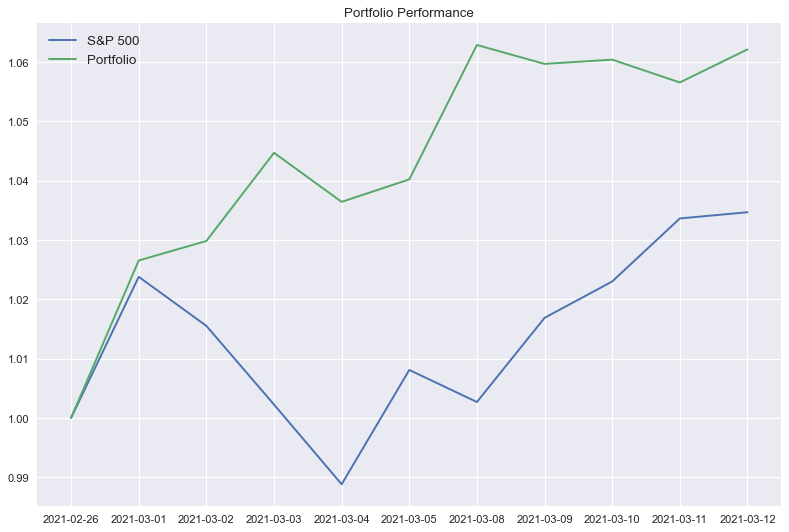

In [4]:
start = ['2021-02-26', '2021-03-05','2021-03-12','2021-03-19','2021-03-26','2021-04-02','2021-04-09','2021-04-16']
weeks = [0,1]
portfolio_performance = []
final_performance = []
index = []
returns = []
for week in weeks:
    portfolio, portfolio_delta, longs, shorts, long_prices, short_prices, long_returns, short_returns, performance = weekly_performance(weeks, week, start, long_weights, short_weights, long_stocks, short_stocks)
    if week != 0:
        index.append(long_prices.index[1:])
    else:
        index.append(long_prices.index)
    for i in range(len(performance)):
        portfolio_performance.append(performance[i])
    returns.append(performance)
    
returns_=[]
for i in range(len(returns)):
    for j in range(len(returns[i])):
        returns_.append(returns[i][j])
        

portfolio_performance = np.cumprod(1 + pd.Series(portfolio_performance))
for i in range(len(portfolio_performance)+1):
    if i == 0:
        final_performance.append(1)
    else:
        final_performance.append(portfolio_performance[i-1])
std = np.std(returns_)  
sharpe_ratio = ((final_performance[-1]/final_performance[0])**(1/len(final_performance))-1)/std
index_= []
for i in range(len(index)):
    for j in range(len(index[i])):
        index_.append(index[i][j])
        
sp500 = pdr.get_data_yahoo('^GSPC', start=start[0], end=end_date)['Adj Close']
sp500 = sp500.pct_change()
sp500 = np.cumprod(1 + pd.Series(sp500))
sp500_ = []
for i in range(len(sp500)):
    if i == 0:
        sp500_.append(1)
    else:
        sp500_.append(sp500[i])
for i in range(len(index_)):
    a = str(index_[i])[0:10]
    index_[i] = a
print('\n\nSHARPE RATIO: ', round(sharpe_ratio,2))
print('CORRELATION WITH THE MARKET: ', round(np.corrcoef(pd.Series(final_performance).pct_change().dropna(), pd.Series(sp500_).pct_change().dropna())[0,1], 2))
plt.plot(index_, sp500_, label = 'S&P 500')
plt.plot(index_, final_performance, label= 'Portfolio')
plt.title('Portfolio Performance')
plt.legend(loc="upper left", fontsize =12)

plt.show()